# Benchmark many models on repetitive sums dataset using together ai api

We use together.ai to call many models. They offer a variety of models for affordable costs.  

This time, for inference, we use the following technique:  
1. provide a prompt with a chat history containing a system, user, and an assistant message  
2. the assistant message is then completed by the LLM, with up to 3 new tokens allowed  
3. we extract the int from the response to get rid of punctuation and other noise.  

In case of a failed int extraction, we still return 0, like all previous notebooks, when the model failed to answer with an int or a correct JSON.  

## install libs

In [1]:
!pip install together datasets

## inference function

In [2]:
import os
from together import Together
from google.colab import userdata
import time

client = Together(api_key=userdata.get('TOGETHER_AI'))

# def safe_int_conversion(x):
#     try:
#         return int(x)
#     except (ValueError, TypeError):
#         return 0

def extract_number(input_str):
  try:
    return int(''.join(filter(str.isdigit, input_str)))
  except ValueError:
    return 0

extract_number("bla bla . bla bla"), extract_number("bla bla 22 bla bla")

def get_sum_result(current_sum, curr_model):
  while True:
    try:
      response = client.chat.completions.create(
          model=curr_model,
          messages=[
              {"role": "system", "content": "You are a helpful assistant. Answer using a single token."},
              {"role": "user", "content": f"What is the result of this sum : {current_sum} ?"},
              {"role": "assistant", "content": "The result is : "}
              ],
          max_tokens = 3
      )
      return extract_number(response.choices[0].message.content)
    except Exception: #catch http 429 here
      print("Retrying...")
      time.sleep(60)


model_name = "meta-llama/Llama-3-8b-chat-hf"
get_sum_result("50+50", model_name)

100

## benchmark functions

In [3]:
from functools import partial
import concurrent.futures
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def perform_parallel_sums(sums_to_compute, model_name):
    # Number of parallel calls
    N = 4

    # Create a partial function with model_name argument
    partial_get_sum_result = partial(get_sum_result, curr_model=model_name)

    # Create a ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=N) as executor:
        # Wrap the executor.map with tqdm for progress bar
        inferred_sums = list(tqdm(executor.map(partial_get_sum_result, sums_to_compute), total=len(sums_to_compute)))

    return inferred_sums

def get_benchmark_df(df, models_to_test, number_of_samples=10):

  inferred_sums = []
  for curr_model in tqdm(models_to_test, desc='inferring on models'):
      inferred_sums.append(perform_parallel_sums(df['sum'].tolist()[:number_of_samples], curr_model))

  df_list = []
  df_list.append(df.head(number_of_samples))

  for inference_results, model_name in zip(inferred_sums, models_to_test):
    df_list.append(pd.DataFrame(inference_results, columns=[model_name]))
  return pd.concat(df_list, axis=1)

def analyze_model(df, model_name):
  df = df.copy(deep=True)

  # count parsing failures
  number_of_parsing_failures = len(df[df[model_name] == 0])

  # compute accuracy including JSON parse errors as bad answers
  df['is_correct'] = df['result'].astype(int) == df[model_name]
  mean_accuracy = df.is_correct.mean()*100

  # exclude parsing failures from stat count as "0" is not a significant result to measure
  df = df[df[model_name] != 0]

  # select the failed results to compute error stats
  wrong_answers = df[df.is_correct == False].copy(deep=True)


  if len(wrong_answers) == 0:
    return {
        'model_name' : model_name,
        'avg_accuracy' : mean_accuracy,
        'error_mean' : 0,
        'error_median' : 0,
        'error_std' : 0,
        'error_min' : 0,
        'error_max' : 0,
        'parsing_failure_count' : number_of_parsing_failures
    }
  else:
    wrong_answers['error_abs'] = abs(wrong_answers['result'].astype(int) - wrong_answers[model_name])
    wrong_answers['error_prop'] = wrong_answers['error_abs'] / wrong_answers['result'].astype(int)
    return {
        'model_name' : model_name,
        'avg_accuracy' : mean_accuracy,
        'error_mean' : wrong_answers['error_abs'].mean(),
        'error_median' : wrong_answers['error_abs'].median(),
        'error_std' : wrong_answers['error_abs'].std(),
        'error_min' : wrong_answers['error_abs'].min(),
        'error_max' : wrong_answers['error_abs'].max(),
        'parsing_failure_count' : number_of_parsing_failures
    }

def get_stats_recap(benchmark_df, models_to_test):
  results = []
  for model_name in models_to_test:
    results.append(analyze_model(benchmark_df, model_name))

  return pd.DataFrame(results)

def show_model_results(df, model_name):
  df['is_correct'] = df['result'].astype(int) == df[model_name]

  sns.set_theme(style="whitegrid")

  # Order the results
  results = df['result'].astype(int).unique()
  results.sort()

  # set the high and width
  plt.figure(figsize=(20, 2))

  # Create the barplot
  g = sns.barplot(x="result", y=[1]*len(df), data=df, order=results, hue="is_correct", palette={False:"#EA5455", True:"#34A853"})

  # pivot label
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

  # Add title and labels
  plt.title(f"Model : {model_name} - Position of correct sums")
  plt.xlabel("Sum")
  plt.show()


## Load dataset

In [4]:
from datasets import load_dataset

dataset_ds = load_dataset("the-french-artist/repetitive_sums_benchmark", split='train')
dataset_ds

Dataset({
    features: ['sum', 'result'],
    num_rows: 99
})

In [5]:
additions_df = dataset_ds.to_pandas()

## Run complete dataset inference

In [15]:
models_to_test = [
    "meta-llama/Llama-3-8b-chat-hf",
    "meta-llama/Llama-3-70b-chat-hf",
    "google/gemma-7b-it",
    "google/gemma-7b",
    "google/gemma-2b-it",
    "google/gemma-2b",
    "Qwen/Qwen1.5-7B-Chat",
    "Qwen/Qwen1.5-14B-Chat",
    "Qwen/Qwen1.5-32B-Chat",
    "Qwen/Qwen1.5-72B-Chat",
    "Qwen/Qwen2-72B-Instruct",
    "mistralai/Mixtral-8x22B",
    "mistralai/Mixtral-8x22B-Instruct-v0.1",
    "mistralai/Mistral-7B-Instruct-v0.1",
    "mistralai/Mistral-7B-Instruct-v0.3",
    "mistralai/Mistral-7B-Instruct-v0.2",
    "zero-one-ai/Yi-34B-Chat",
    "NousResearch/Nous-Hermes-2-Yi-34B",
    "microsoft/WizardLM-2-8x22B",
    "WizardLM/WizardLM-13B-V1.2",


]

number_of_samples = 100

benchmark_df = get_benchmark_df(additions_df, models_to_test, number_of_samples)
benchmark_df.head()

inferring on models:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

,sum,result,meta-llama/Llama-3-8b-chat-hf,meta-llama/Llama-3-70b-chat-hf,google/gemma-7b-it,google/gemma-7b,google/gemma-2b-it,google/gemma-2b,Qwen/Qwen1.5-7B-Chat,Qwen/Qwen1.5-14B-Chat,...,Qwen/Qwen2-72B-Instruct,mistralai/Mixtral-8x22B,mistralai/Mixtral-8x22B-Instruct-v0.1,mistralai/Mistral-7B-Instruct-v0.1,mistralai/Mistral-7B-Instruct-v0.3,mistralai/Mistral-7B-Instruct-v0.2,zero-one-ai/Yi-34B-Chat,NousResearch/Nous-Hermes-2-Yi-34B,microsoft/WizardLM-2-8x22B,WizardLM/WizardLM-13B-V1.2
0,1+1,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1,1+1+1,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2,1+1+1+1,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
3,1+1+1+1+1,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
4,1+1+1+1+1+1,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


In [16]:
get_stats_recap(benchmark_df, models_to_test)

,model_name,avg_accuracy,error_mean,error_median,error_std,error_min,error_max,parsing_failure_count
0,meta-llama/Llama-3-8b-chat-hf,18.181818,30.123457,29.0,21.926230,1,69,0
1,meta-llama/Llama-3-70b-chat-hf,22.222222,9.883117,8.0,7.290899,1,26,0
2,google/gemma-7b-it,12.121212,36.448276,36.0,24.081624,1,78,0
3,google/gemma-7b,13.131313,47.755814,54.0,29.661199,1,99,0
4,google/gemma-2b-it,8.080808,44.989011,45.0,26.357581,1,89,0
5,google/gemma-2b,8.080808,36.417582,35.0,24.624769,1,80,0
6,Qwen/Qwen1.5-7B-Chat,13.131313,35.965116,35.5,24.258630,1,78,0
7,Qwen/Qwen1.5-14B-Chat,14.141414,29.411765,30.0,16.928628,1,60,0
8,Qwen/Qwen1.5-32B-Chat,21.212121,12.807692,11.0,9.458121,1,36,0
9,Qwen/Qwen1.5-72B-Chat,20.202020,13.772152,9.0,11.787596,1,40,0


<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


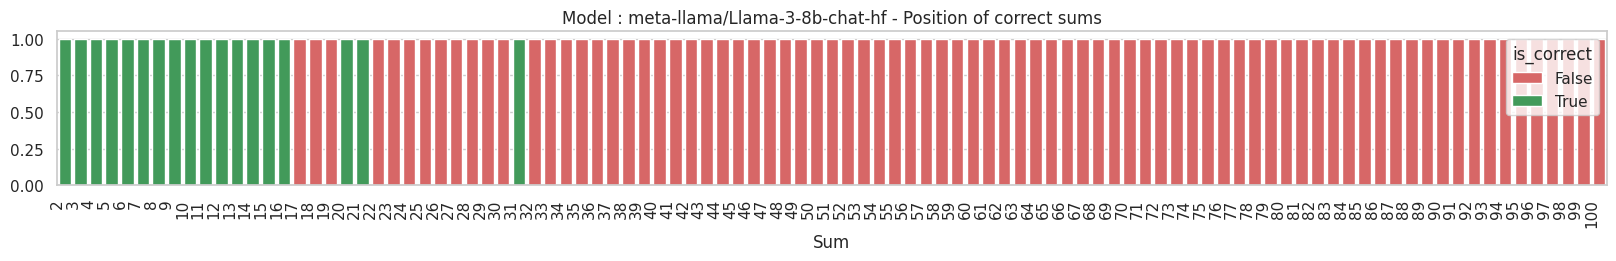

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


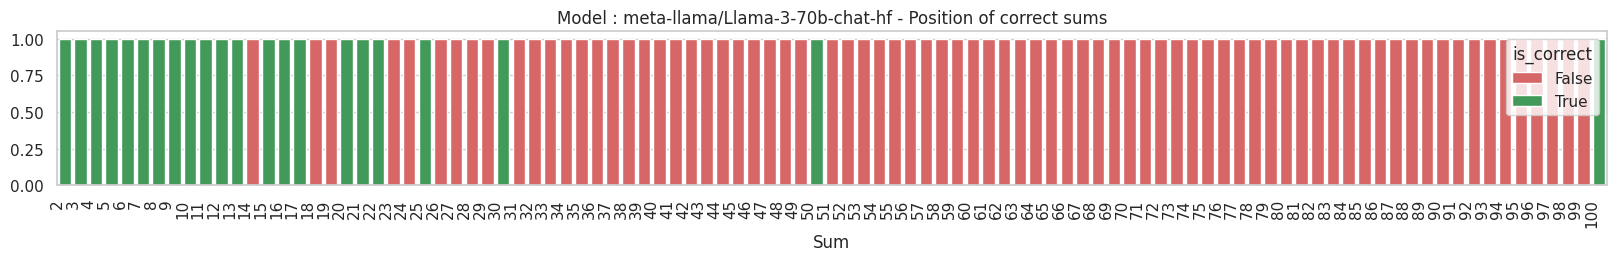

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


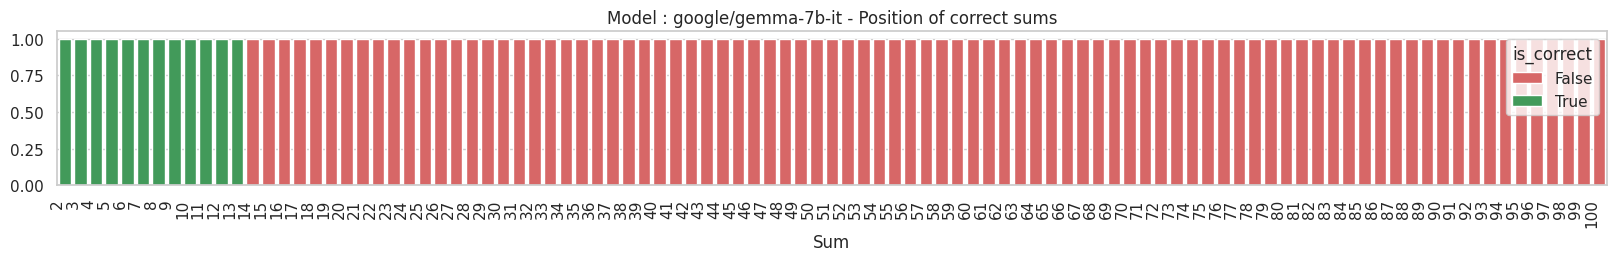

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


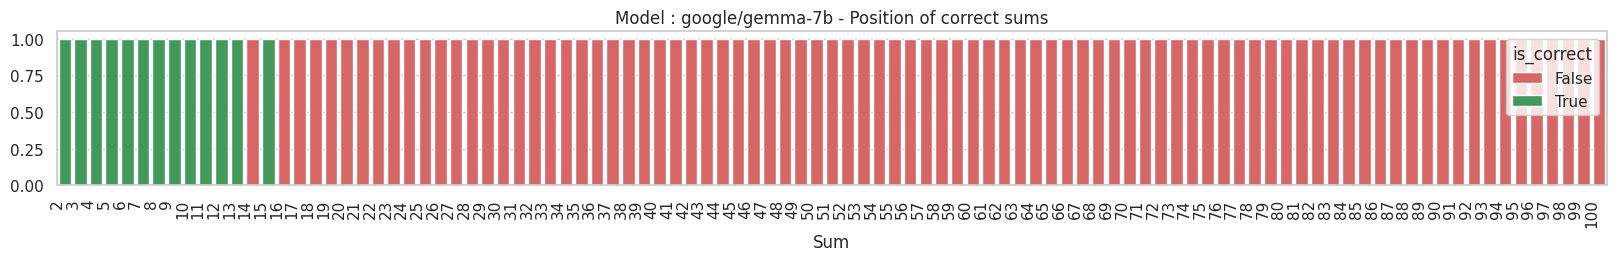

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


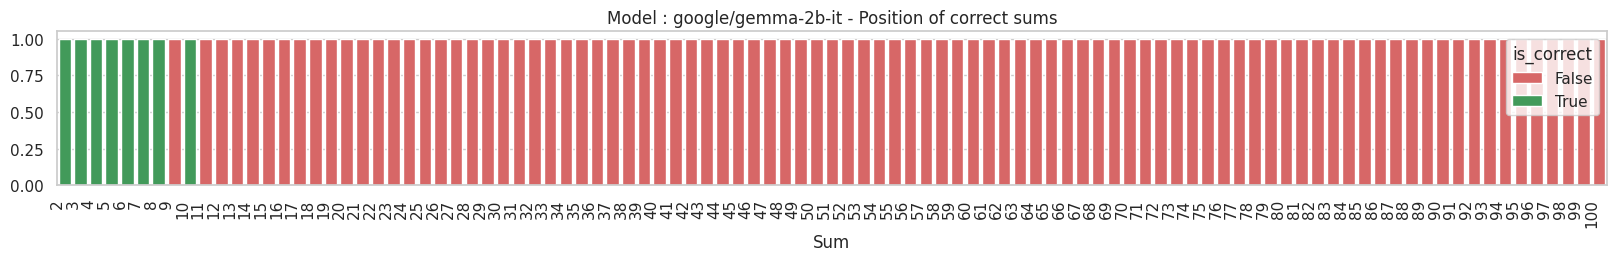

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


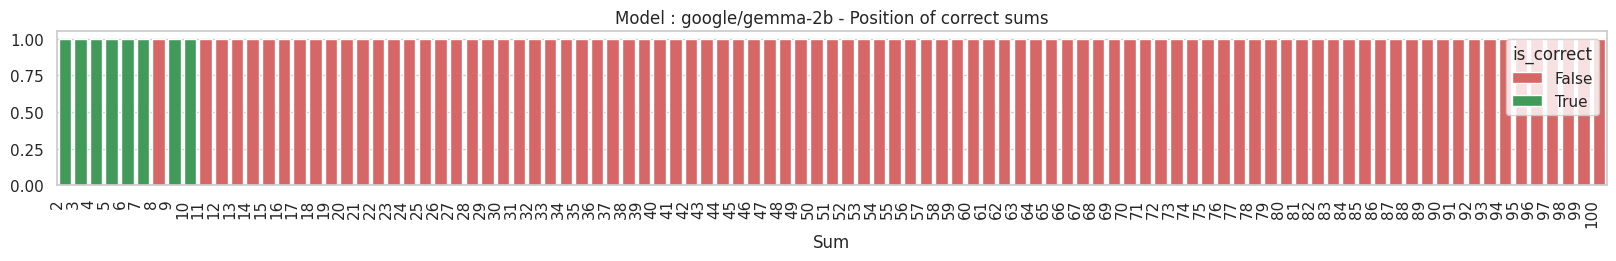

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


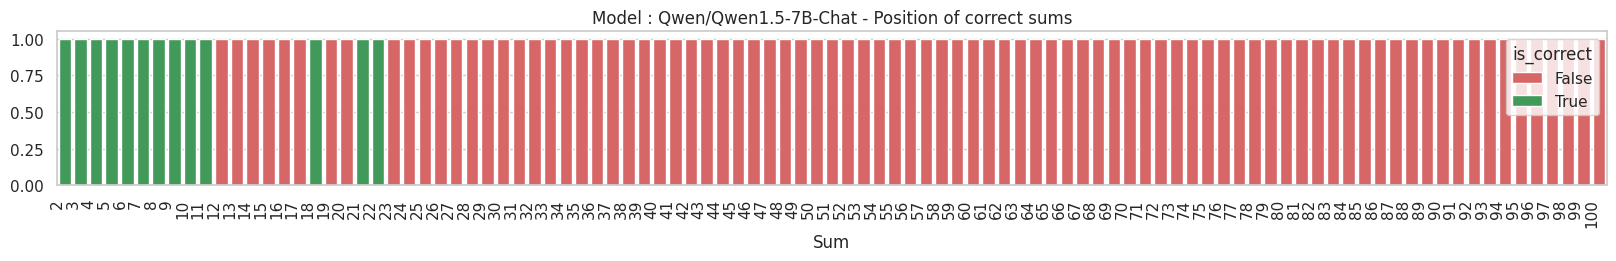

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


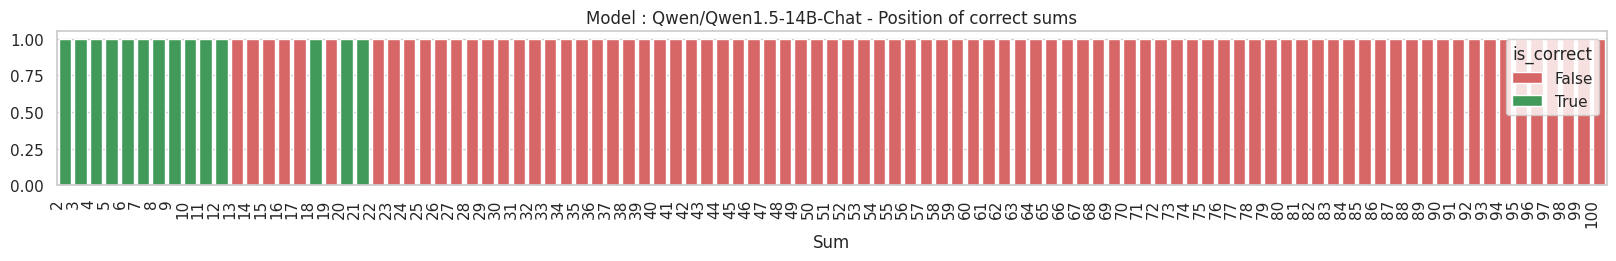

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


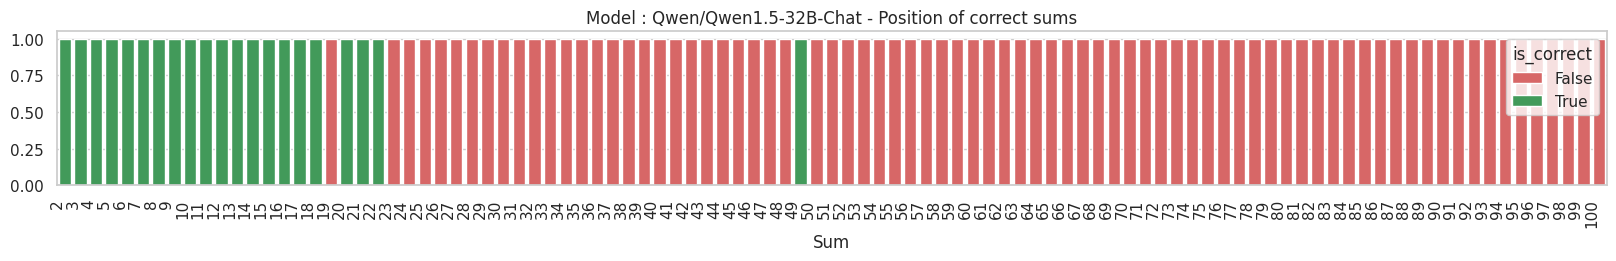

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


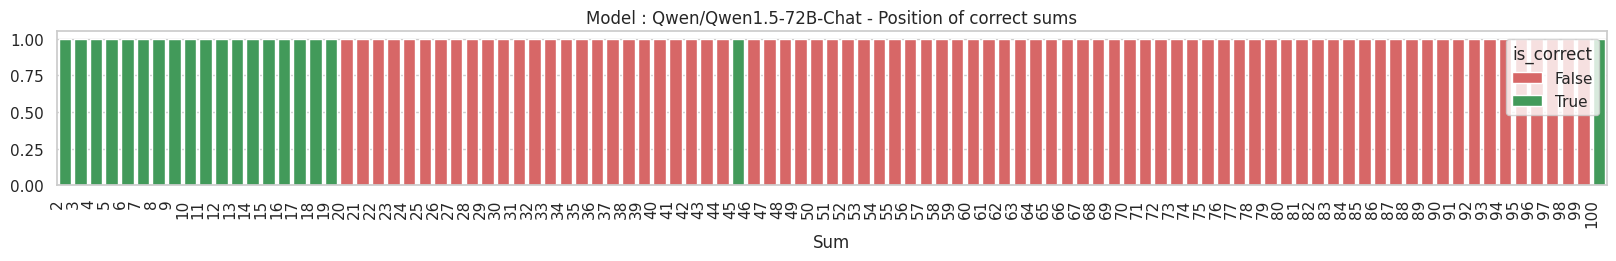

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


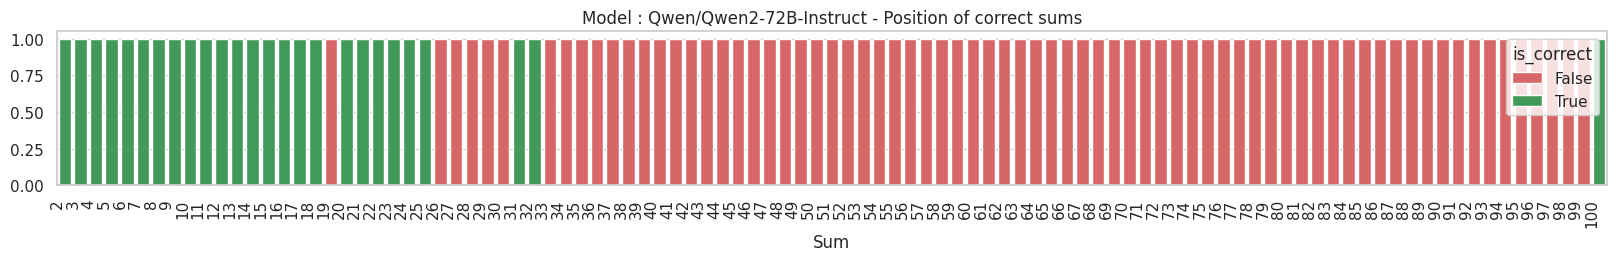

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


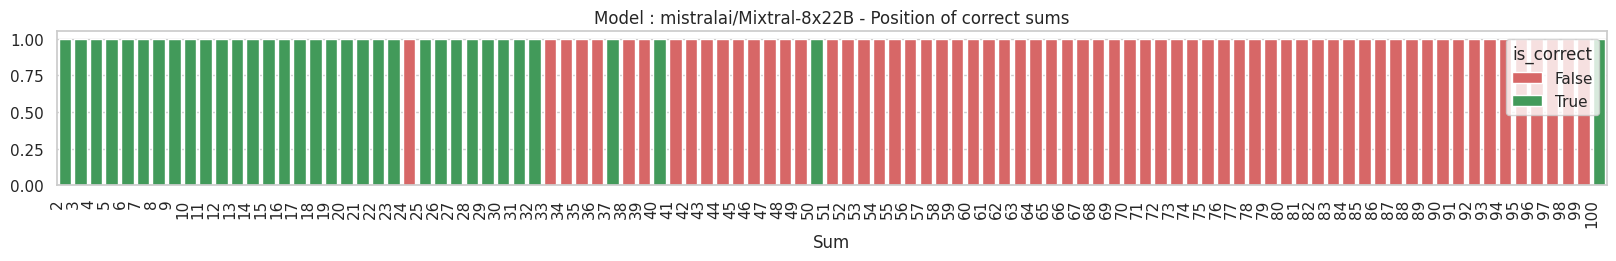

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


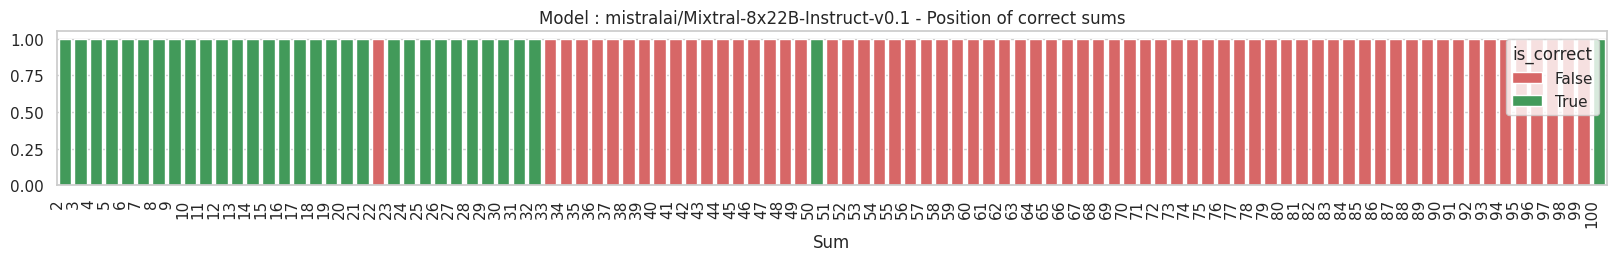

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


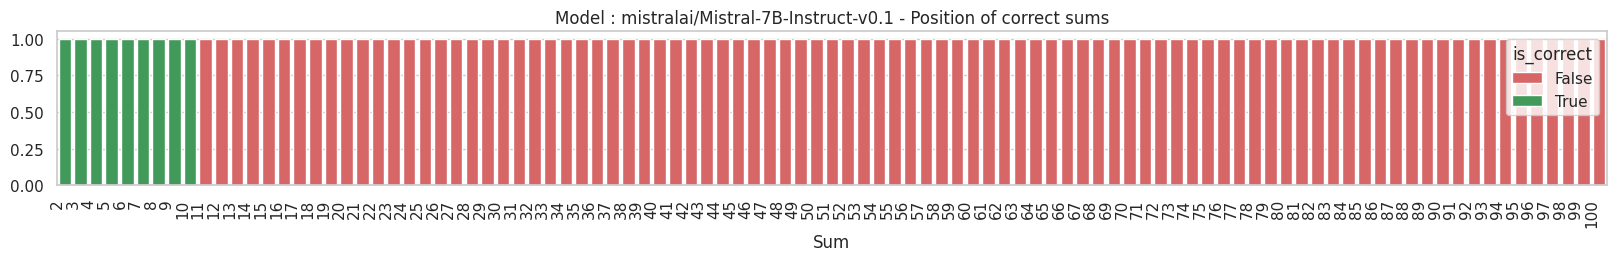

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


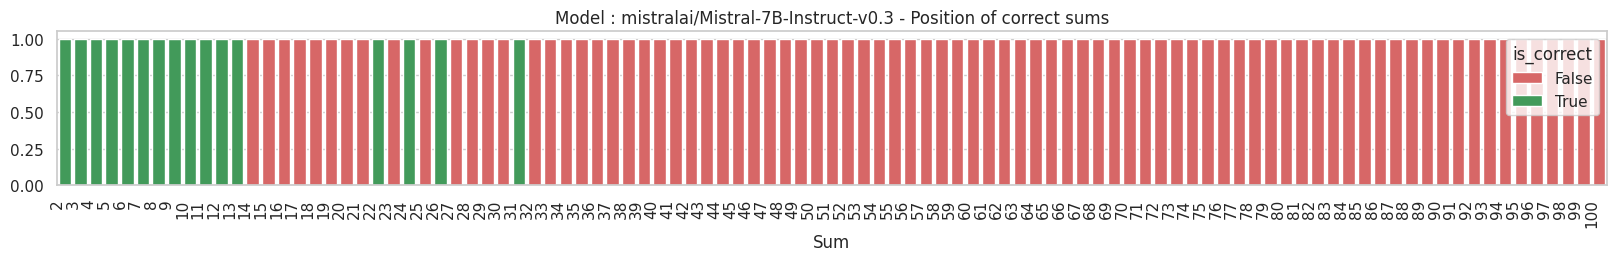

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


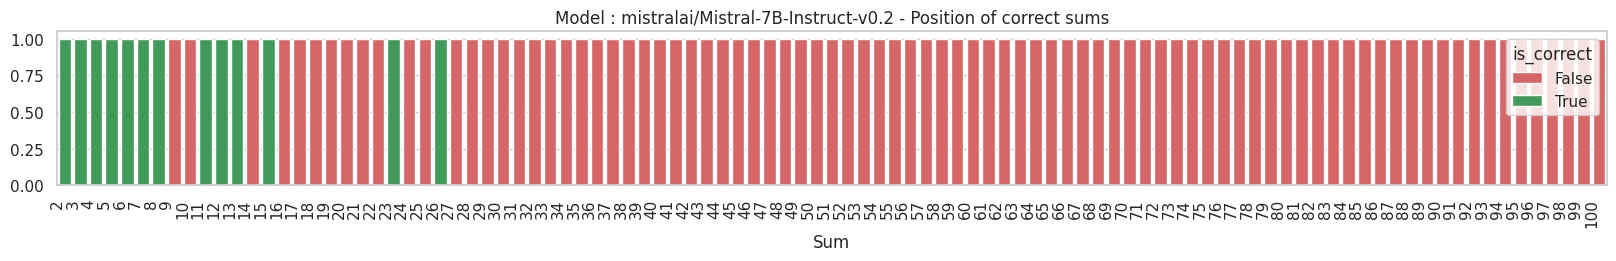

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


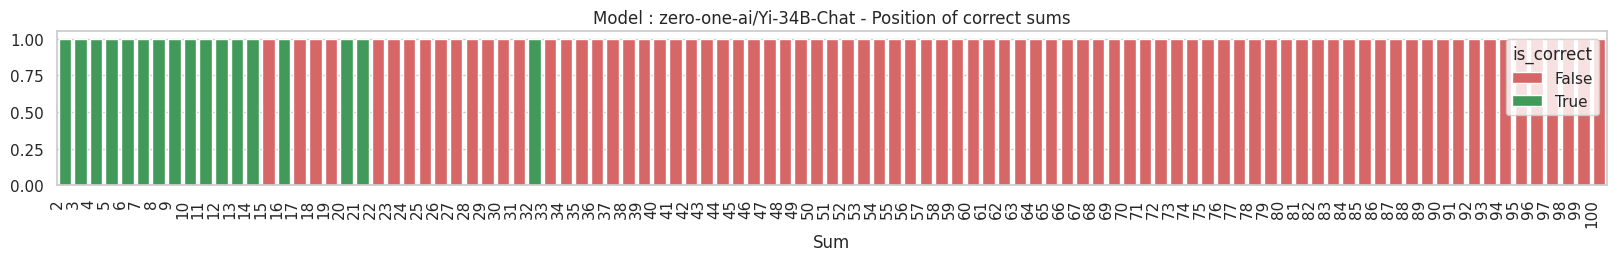

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


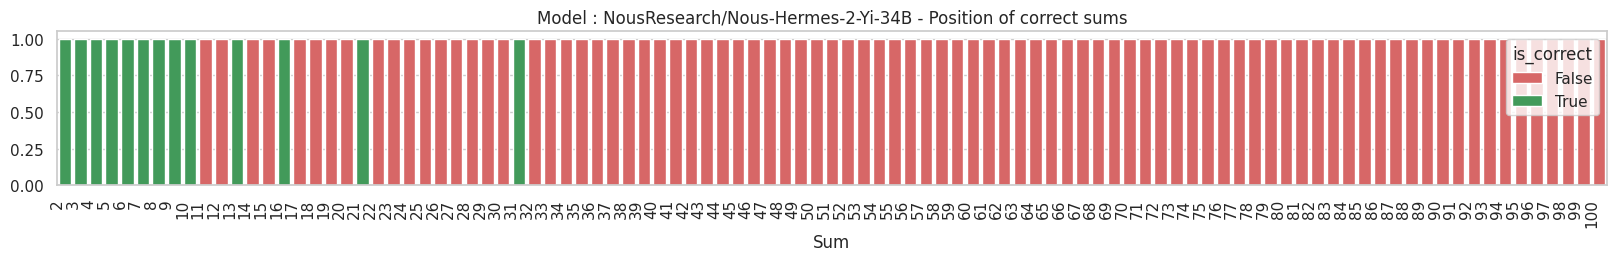

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


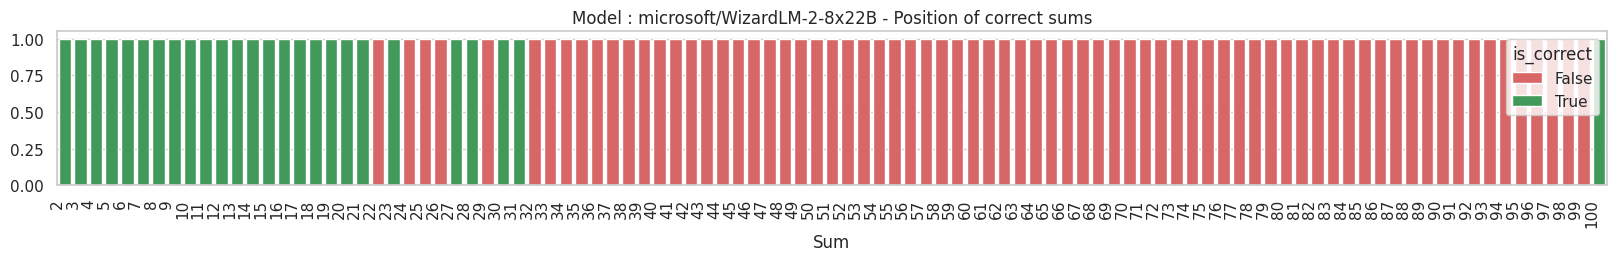

<ipython-input-3-dd08329e15a8>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


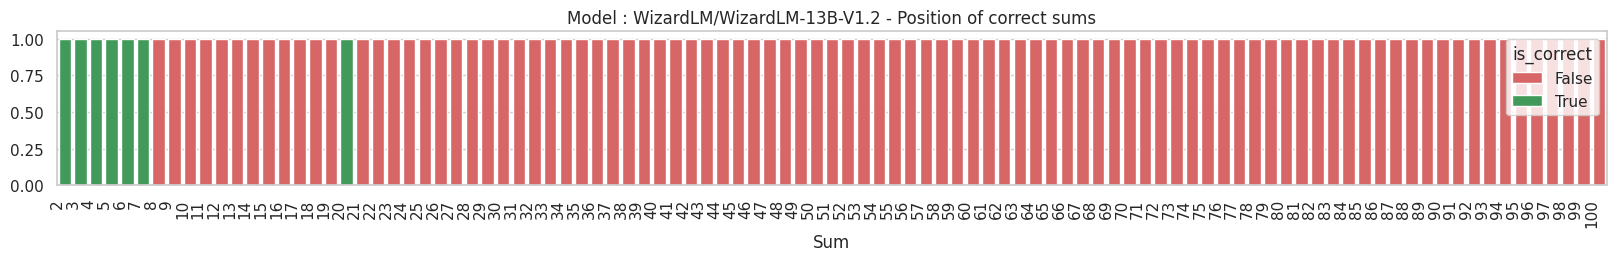

In [17]:
for curr_model in models_to_test:
  show_model_results(benchmark_df, curr_model)

In [18]:
benchmark_df

,sum,result,meta-llama/Llama-3-8b-chat-hf,meta-llama/Llama-3-70b-chat-hf,google/gemma-7b-it,google/gemma-7b,google/gemma-2b-it,google/gemma-2b,Qwen/Qwen1.5-7B-Chat,Qwen/Qwen1.5-14B-Chat,...,mistralai/Mixtral-8x22B,mistralai/Mixtral-8x22B-Instruct-v0.1,mistralai/Mistral-7B-Instruct-v0.1,mistralai/Mistral-7B-Instruct-v0.3,mistralai/Mistral-7B-Instruct-v0.2,zero-one-ai/Yi-34B-Chat,NousResearch/Nous-Hermes-2-Yi-34B,microsoft/WizardLM-2-8x22B,WizardLM/WizardLM-13B-V1.2,is_correct
0,1+1,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,True
1,1+1+1,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,True
2,1+1+1+1,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,True
3,1+1+1+1+1,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,True
4,1+1+1+1+1+1,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,96,31,100,21,1,10,100,22,40,...,100,100,16,31,26,32,31,100,25,False
95,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,97,31,100,22,1,10,100,22,40,...,100,100,16,31,26,32,31,100,25,False
96,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,98,31,100,22,1,10,100,22,40,...,100,100,16,31,26,32,31,100,25,False
97,1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+1+...,99,31,100,22,1,10,102,22,40,...,100,100,16,31,26,32,31,100,25,False


## push results to hub

In [20]:
from datasets import Dataset

benchmark_ds = Dataset.from_pandas(benchmark_df, preserve_index=False)
benchmark_ds

Dataset({
    features: ['sum', 'result', 'meta-llama/Llama-3-8b-chat-hf', 'meta-llama/Llama-3-70b-chat-hf', 'google/gemma-7b-it', 'google/gemma-7b', 'google/gemma-2b-it', 'google/gemma-2b', 'Qwen/Qwen1.5-7B-Chat', 'Qwen/Qwen1.5-14B-Chat', 'Qwen/Qwen1.5-32B-Chat', 'Qwen/Qwen1.5-72B-Chat', 'Qwen/Qwen2-72B-Instruct', 'mistralai/Mixtral-8x22B', 'mistralai/Mixtral-8x22B-Instruct-v0.1', 'mistralai/Mistral-7B-Instruct-v0.1', 'mistralai/Mistral-7B-Instruct-v0.3', 'mistralai/Mistral-7B-Instruct-v0.2', 'zero-one-ai/Yi-34B-Chat', 'NousResearch/Nous-Hermes-2-Yi-34B', 'microsoft/WizardLM-2-8x22B', 'WizardLM/WizardLM-13B-V1.2', 'is_correct'],
    num_rows: 99
})

In [23]:
from google.colab import userdata

benchmark_ds.push_to_hub('the-french-artist/repetitive_sums_benchmark_20_models_results', token=userdata.get('HF_TOKEN'))

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/the-french-artist/repetitive_sums_benchmark_20_models_results/commit/a170cd10e2296ac4e8b8e33a3940cf806b5ea15a', commit_message='Upload dataset', commit_description='', oid='a170cd10e2296ac4e8b8e33a3940cf806b5ea15a', pr_url=None, pr_revision=None, pr_num=None)

In [26]:
recap_df = get_stats_recap(benchmark_df, models_to_test)
leaderboard_df = recap_df.sort_values('avg_accuracy', ascending=False)
leaderboard_df

,model_name,avg_accuracy,error_mean,error_median,error_std,error_min,error_max,parsing_failure_count
11,mistralai/Mixtral-8x22B,34.343434,15.569231,11.0,13.677044,1,43,0
12,mistralai/Mixtral-8x22B-Instruct-v0.1,32.323232,16.059701,11.0,13.026640,1,43,0
10,Qwen/Qwen2-72B-Instruct,26.262626,23.534247,22.0,15.923500,1,54,0
18,microsoft/WizardLM-2-8x22B,26.262626,13.027397,10.0,10.825603,1,38,0
1,meta-llama/Llama-3-70b-chat-hf,22.222222,9.883117,8.0,7.290899,1,26,0
8,Qwen/Qwen1.5-32B-Chat,21.212121,12.807692,11.0,9.458121,1,36,0
9,Qwen/Qwen1.5-72B-Chat,20.202020,13.772152,9.0,11.787596,1,40,0
0,meta-llama/Llama-3-8b-chat-hf,18.181818,30.123457,29.0,21.926230,1,69,0
16,zero-one-ai/Yi-34B-Chat,17.171717,40.512195,29.5,60.798847,1,340,0
14,mistralai/Mistral-7B-Instruct-v0.3,16.161616,29.819277,28.0,21.680690,1,69,0


In [27]:
leaderboard_ds = Dataset.from_pandas(leaderboard_df, preserve_index=False)
leaderboard_ds.push_to_hub('the-french-artist/repetitive_sums_benchmark_leaderboard', token=userdata.get('HF_TOKEN'))

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/the-french-artist/repetitive_sums_benchmark_leaderboard/commit/8f4e81e6b612e332ef700e429aabc6f5f60059a5', commit_message='Upload dataset', commit_description='', oid='8f4e81e6b612e332ef700e429aabc6f5f60059a5', pr_url=None, pr_revision=None, pr_num=None)